In [46]:
from ydata_profiling import ProfileReport
import pandas as pd
import numpy as np
import pandas_datareader as pdr  # to install: !pip install pandas_datareader
from datetime import datetime
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.formula.api import ols as sm_ols
from statsmodels.iolib.summary2 import summary_col # nicer tables
from sklearn.model_selection import train_test_split
from sklearn import set_config
from sklearn.calibration import CalibrationDisplay
from sklearn.compose import ColumnTransformer, make_column_selector, make_column_transformer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import ConfusionMatrixDisplay,DetCurveDisplay,PrecisionRecallDisplay,RocCurveDisplay,classification_report,r2_score
from sklearn.model_selection import GridSearchCV,KFold,cross_validate,train_test_split
from df_after_transform import df_after_transform
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.linear_model import Lasso, Ridge
from sklearn.feature_selection import SelectKBest, f_classif, VarianceThreshold
set_config(display="diagram")

In [47]:
ceo_df = pd.read_csv('./input_data_clean/CEO_DF.csv')
bod_df = pd.read_csv('./input_data_clean/BOD_DF.csv')
firms_df = pd.read_csv('./input_data_clean/FIRMS.csv')

In [48]:
small_ceo_df = ceo_df[ceo_df['size_category'] == 'Small']
medium_ceo_df = ceo_df[ceo_df['size_category'] == 'Medium']
large_ceo_df = ceo_df[ceo_df['size_category'] == 'Large']

small_bod_df = bod_df[bod_df['size_category'] == 'Small']
medium_bod_df = bod_df[bod_df['size_category'] == 'Medium']
large_bod_df = bod_df[bod_df['size_category'] == 'Large']


In [49]:
small_bod_df.describe()


,Unnamed: 0.3,Unnamed: 0.2,Unnamed: 0.1,Unnamed: 0,gvkey,total_sec,othcomp,noneq_incent,cash_fees,stock_awards,...,total_option_awards,mkvalt,liquidity,net_income,num_employees,market_value,debt_to_equity,assets_in_place,capex_by_assets,return_on_equity
count,1695.000000,1695.000000,1695.000000,1695.000000,1695.000000,1695.000000,1695.000000,1695.000000,1695.000000,1695.000000,...,1695.000000,1695.000000,962.000000,863.000000,1678.000000,1483.000000,1691.000000,1471.000000,862.000000,863.000000
mean,5208.500295,5208.500295,5208.500295,5208.500295,69404.182301,255.951124,13.798124,0.089735,88.760503,137.873509,...,197.800002,6584.102963,0.185680,226.071825,11.132241,5763.166202,1.970995,0.297067,0.042000,0.055908
std,2435.526633,2435.526633,2435.526633,2435.526633,69874.592257,304.621274,196.070712,2.168082,68.555513,190.559313,...,786.550712,2170.455107,0.176983,475.396554,22.918518,3195.470105,25.341185,0.351750,0.040841,0.096929
min,0.000000,0.000000,0.000000,0.000000,1045.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,62.891700,-0.394751,-6382.000000,0.052000,62.891700,-816.013699,0.000000,0.000272,-0.714971
25%,3382.000000,3382.000000,3382.000000,3382.000000,10791.000000,182.534000,0.000000,0.000000,60.000000,75.014000,...,0.000000,5194.681300,0.049085,96.648500,1.667750,3634.795400,0.924945,0.022784,0.016283,0.026889
50%,5326.000000,5326.000000,5326.000000,5326.000000,28742.000000,222.006000,0.000000,0.000000,86.000000,114.000000,...,0.000000,7017.656600,0.162169,209.238000,6.000000,5270.226100,1.716578,0.166509,0.030069,0.061015
75%,7599.000000,7599.000000,7599.000000,7599.000000,150937.000000,279.967000,0.000000,0.000000,110.875000,159.972000,...,171.216000,8379.176000,0.283026,365.007000,11.245000,7537.069700,4.574117,0.438989,0.054034,0.098968
max,8771.000000,8771.000000,8771.000000,8771.000000,316056.000000,7733.603000,7688.890000,78.000000,941.186000,2575.027000,...,11948.963000,9984.534800,0.744295,2748.800000,236.100000,39174.120000,124.827692,2.075980,0.467642,0.340002


In [50]:
df = medium_bod_df
df.drop(['Unnamed: 0', 'Unnamed: 0.1', 'Unnamed: 0.3', 'Unnamed: 0.2', 'gvkey', 'total_sec'], axis=1, inplace=True)

# Create boolean masks for the train and holdout periods
train_mask = df.loc[(df['year'] >= 2010) & (df['year'] <= 2016)]
holdout_mask = df.loc[(df['year'] >= 2017) & (df['year'] <= 2019)]

y = np.log(train_mask.total_director_comp)
X = train_mask.drop('total_director_comp', axis=1)

VarY = holdout_mask[['signature_index', 'total_director_comp']]
VarY.to_csv('./Saved/medium_bod_df.csv', index=False)

holdout_set = holdout_mask


holdout_X = holdout_set.drop(['signature_index', 'total_director_comp'], axis=1)

rng = np.random.RandomState(0)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=rng)

missing_cols = set(X_train.columns) - set(holdout_X.columns)
for col in missing_cols:
    holdout_X[col] = 0
holdout_X = holdout_X[X_train.columns]

/var/folders/29/vl12lkgs28xgjpc6t0_jg9040000gn/T/ipykernel_3583/1117036797.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(['Unnamed: 0', 'Unnamed: 0.1', 'Unnamed: 0.3', 'Unnamed: 0.2', 'gvkey', 'total_sec'], axis=1, inplace=True)


In [51]:
cv = KFold(10)

In [52]:
numer_pipe = make_pipeline(SimpleImputer(strategy="mean"), StandardScaler())
cat_pipe = make_pipeline(OneHotEncoder())

preproc_pipe = make_column_transformer(
    (numer_pipe, make_column_selector(dtype_include=np.number)),
    remainder="drop",
)
# pipe = Pipeline([('columntransformer',preproc_pipe),
#                  ('feature_select',SelectKBest()), 
#                  ('clf', Ridge())
#                 ])

ridge_pipe = Pipeline([
    ('preprocessor', preproc_pipe),
    ('ridge', Ridge())
])

In [53]:
y_train = y_train.replace(-np.inf, 0)

In [54]:
y_train.describe()

count    2055.000000
mean        7.631251
std         0.777642
min         0.000000
25%         7.350967
50%         7.744594
75%         7.996934
max         9.175288
Name: total_director_comp, dtype: float64

In [55]:
alphas = list(np.linspace(0, 300, 25))
parameters = {'ridge__alpha': alphas}

grid_search = GridSearchCV(estimator=ridge_pipe, 
                           param_grid=parameters,
                           cv=cv,
                           scoring='r2',
                           error_score='raise')

results = grid_search.fit(X_train, y_train)

<AxesSubplot:title={'center':'CV score by alpha'}, xlabel='alpha'>

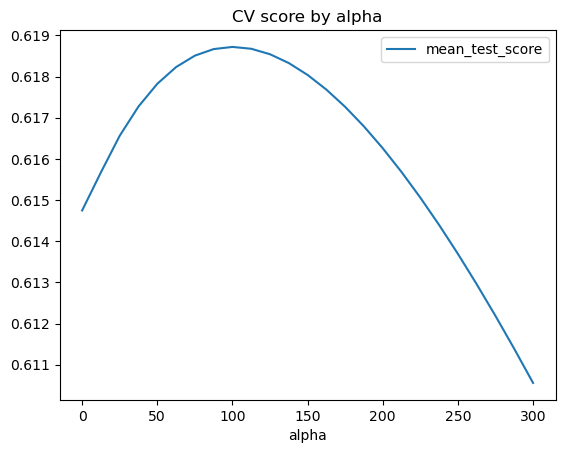

In [56]:
results_df = pd.DataFrame(results.cv_results_).set_index('params')
results_df['alpha'] = [c['ridge__alpha'] for c in results_df.index]
results_df = results_df.sort_values('alpha')
results_df.plot(x='alpha', y='mean_test_score', kind='line', title='CV score by alpha')

<AxesSubplot:title={'center':'CV score by alpha'}, xlabel='alpha'>

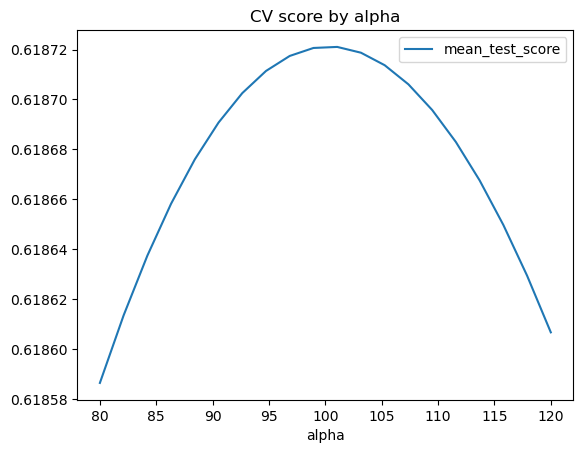

In [57]:
alphas = list(np.linspace(80, 120,20))
parameters = {'ridge__alpha': alphas}

grid_search = GridSearchCV(estimator=ridge_pipe, 
                           param_grid=parameters,
                           cv=cv,
                           scoring='r2')

results = grid_search.fit(X_train, y_train)

results_df = pd.DataFrame(results.cv_results_).set_index('params')
# extract alpha from the params variable
results_df['alpha'] = [c['ridge__alpha'] for c in results_df.index]
results_df = results_df.sort_values('alpha')
results_df.plot(x='alpha',y='mean_test_score',kind='line',
                title='CV score by alpha')

In [58]:
best_alpha = results_df.query('rank_test_score == 1')['param_ridge__alpha'][0]
print('The optimal ridge alpha is: %.5f' % best_alpha)

The optimal ridge alpha is: 101.05263


In [59]:
print('The mean test score for this alpha is: %.5f' % results_df.query('rank_test_score == 1')['mean_test_score'][0])

The mean test score for this alpha is: 0.61872


In [60]:
cv = KFold(10)

numer_pipe = make_pipeline(SimpleImputer(strategy="mean"), StandardScaler())

cat_pipe = make_pipeline(OneHotEncoder())

preproc_pipe = make_column_transformer(
    (numer_pipe, make_column_selector(dtype_include=np.number)),
    remainder="drop",
)


In [70]:
import warnings

# ignore the specific warning
warnings.filterwarnings("ignore", category=RuntimeWarning)
from sklearn.feature_selection import SelectPercentile, f_regression

pipe = Pipeline([('columntransformer',preproc_pipe),
                 ('feature_select',SelectPercentile(score_func=f_regression)), 
                 ('clf', Ridge())
                ])

param_grid = {
    # 'feature_select__percentile': [10, 20, 30, 40, 50, 60, 70, 80, 90],
    'feature_select__percentile': [90, 91, 92, 93, 94, 95, 96, 97],
    # 'feature_select__percentile': [83, 84, 85, 86, 87, 88, 89, 90],
    # 'feature_select__percentile': [57, 58, 59 ,60, 61, 62, 63, 64],
    # 'feature_select__percentile': [64, 65, 66, 67, 68, 69 ,70, 71],

    # 'feature_select__percentile': [18, 19, 20, 21, 22, 23, 24, 25],

    # 'clf__alpha': [18, 19, 20, 21, 22, 23, 24, 25], 
    # 'clf__alpha': [0.5, 0.75, 0.9, 1.23, 1.45, 1.57895, 1.7, 1.8],
    # 'clf__alpha': [200, 205, 208, 210, 213, 215, 220, 225],
    # 'clf__alpha': [234, 236, 237, 238, 239 ,240],
    # 'clf__alpha': [120, 130, 140, 150, 160], 
    # 'clf__alpha': [114, 115, 116, 117, 118, 119, 120], 
    # 'clf__alpha': [50, 100, 150, 200, 250, 300], 
    'clf__alpha': [95, 96, 97, 98, 99, 100, 101, 102, 103, 104], 

    # 'clf__alpha': [186, 188, 190, 192, 194, 196], 
    # 'clf__alpha': [105, 107, 109, 111, 112, 113, 114, 115], 
    # 'clf__alpha': [14.5,15,15.5,16, 16.5, 17], 
    # 'clf__alpha': [47, 48, 49, 50, 51, 52, 53, 54], 

# 

}

grid_search = GridSearchCV(estimator=pipe, 
                           param_grid=param_grid,
                           cv=cv,
                           scoring='r2',
                           error_score='raise')

results = grid_search.fit(X_train, y_train)


In [71]:
results_data = pd.DataFrame(results.cv_results_)
results_data = results_data[['params','mean_test_score','std_test_score']]
results_data['alpha'] = results_data['params'].apply(lambda x: x.get('clf__alpha'))
results_data['k'] = results_data['params'].apply(lambda x: x.get('feature_select__percentile'))
results_data.head()

,params,mean_test_score,std_test_score,alpha,k
0,"{'clf__alpha': 95, 'feature_select__percentile...",0.61794,0.143376,95,90
1,"{'clf__alpha': 95, 'feature_select__percentile...",0.61794,0.143376,95,91
2,"{'clf__alpha': 95, 'feature_select__percentile...",0.61794,0.143376,95,92
3,"{'clf__alpha': 95, 'feature_select__percentile...",0.61794,0.143376,95,93
4,"{'clf__alpha': 95, 'feature_select__percentile...",0.61794,0.143376,95,94


Text(45    0.143589
Name: std_test_score, dtype: float64, 45    0.618721
Name: mean_test_score, dtype: float64, 'Best params: k=95, alpha=100     ')

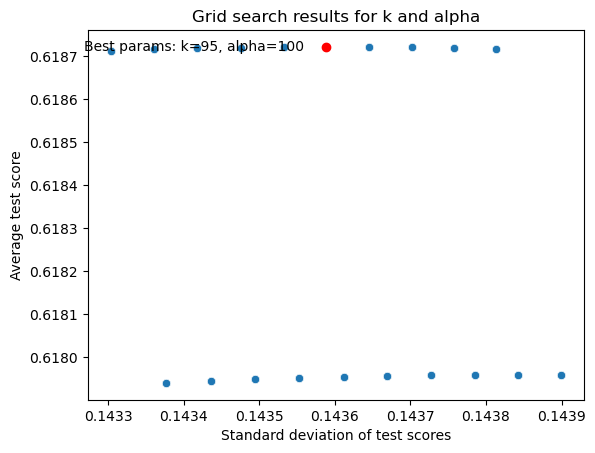

In [72]:
sns.scatterplot(data=results_data, x='std_test_score', y='mean_test_score')
plt.xlabel('Standard deviation of test scores')
plt.ylabel('Average test score')
plt.title('Grid search results for k and alpha')

best_params = grid_search.best_params_
best_k = best_params['feature_select__percentile']
best_alpha = best_params['clf__alpha']
plt.scatter(x=results_data.loc[(results_data['k'] == best_k) 
                                       & (results_data['alpha'] == best_alpha),
                                       'std_test_score'], 
            y=results_data.loc[(results_data['k'] == best_k) 
                                       & (results_data['alpha'] == best_alpha),
                                       'mean_test_score'], color='red')
plt.text(results_data.loc[(results_data['k'] == best_k) 
                                       & (results_data['alpha'] == best_alpha),
                                       'std_test_score'],
         results_data.loc[(results_data['k'] == best_k) 
                                & (results_data['alpha'] == best_alpha),
                                'mean_test_score'], 
         f"Best params: k={best_k}, alpha={best_alpha}     ", ha='right', va='center')

In [73]:
opt_pipe = make_pipeline(preproc_pipe, SelectPercentile(score_func=f_regression, percentile=best_k), Ridge(alpha=best_alpha))
opt_pipe.fit(X_train, y_train)

y_holdout_pred = opt_pipe.predict(holdout_X)

# create a dataframe with the parcel ID and the predicted values
df_out = pd.DataFrame({'signature_index': VarY['signature_index'], 'prediction': np.exp(y_holdout_pred) })
# merged_df = pd.merge(VarY, df_out, on='signature_index')

In [74]:
df_out.to_csv('./Saved/pred_med_bod_df.csv', index=False)